Import Statements

In [496]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geocoder
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import numpy as np
import math
from sklearn import preprocessing
import matplotlib.pyplot as plt

Reading Houston Census 2010 CSV file

In [497]:
df = pd.read_csv("Census_2010_By_SuperNeighborhood.csv")

Formatting the Super Neighborhoods by removing symbols and alternative names

In [498]:
list_names = []

for i in df['Name']:
    if "/" in i:
        list_names.append(i[:i.find("/")-1])
    else :
        list_names.append(i)

df['Name'] = list_names

Fetching the Latitude and Longitude for each Super Neighborhood

In [ ]:
data = []
for i in list_names:
    print (i)
    temp = ""
    temp = i + ", Houston" + ", Texas"
    address = temp
    geolocator = Nominatim(user_agent="my_geocoder")
    location = geolocator.geocode(address)
    if location :
        latitude = location.latitude
        longitude = location.longitude
        data.append([i,latitude,longitude])
    else :
        data.append([i,"NA","NA"])

Creating dataframe to store the fetched data and save it as .csv to verify and correct wrong values

In [499]:
df_latlan = pd.DataFrame(data,columns= ["Name","Latitude","Longitude"])
df_latlan.to_csv('houston_latlon1.csv', index=False)

Reading the .csv file with Latitude and Longitude and adding columns form the Houston Census dataframe

In [500]:
df_latlan = pd.read_csv('houston_latlon.csv')
df_latlan["population_density"] = df["SUM_TotPop"]/df["Shapearea"]
df_latlan["total_housing"] = df["SUM_TotHousing"]/df["Shapearea"]
df_latlan["hispanic_population"] = df["SUM_HispPop"]/df["SUM_TotPop"]
df_latlan["asian_population"] = df["SUM_NH_Asian"]/df["SUM_TotPop"]
df_latlan["white_population"] = df["SUM_NH_White"]/df["SUM_TotPop"]
df_latlan["black_population"] = df["SUM_NH_Black"]/df["SUM_TotPop"]
df_latlan["total_area"] = df["Shapearea"]
df_latlan.head()

,Name,Latitude,Longitude,population_density,total_housing,hispanic_population,asian_population,white_population,black_population,total_area
0,FOURTH WARD,29.756456,-95.380479,0.000299,0.000162,0.183200,0.082711,0.348621,0.359701,1.296982e+07
1,SECOND WARD,29.747542,-95.340107,0.000168,0.000064,0.787098,0.005790,0.078910,0.120481,8.040472e+07
2,DOWNTOWN,29.759724,-95.362707,0.000221,0.000049,0.195382,0.021237,0.364441,0.392558,7.550023e+07
3,CLINTON PARK TRI-COMMUNITY,29.749576,-95.260397,0.000033,0.000015,0.241490,0.002403,0.006007,0.742091,7.655352e+07
4,GREATER UPTOWN,29.746111,-95.463889,0.000214,0.000137,0.148365,0.092355,0.691256,0.046492,2.297921e+08


Storing the Four Square credentials

In [501]:
CLIENT_ID = 'C4ACY4VJAADMCRCUB1VHBZGZLMPOVJSAUQJ0HUVR2NZVTXX4' 
CLIENT_SECRET = 'F2LCCXUR2SUAMY45LHLZLU4Y4BEAUMIMHGA3NI2DSFPARFOP' 
VERSION = '20180605'

Function to Fetch the nearby venues for each neighborhood in it's area

In [502]:
def fetchvenues(names, latitudes, longitudes, total_area):
    #radius = int(math.sqrt(area/3.14))
    LIMIT=100
    venues_list=[]
    for name, lat, lng, area  in zip(names, latitudes, longitudes, total_area):
        #print(name)
        radius = int(math.sqrt(area/3.14))   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Calling the fetchvenues function

In [503]:
houston_venues = fetchvenues(names=df_latlan['Name'],
                                   latitudes=df_latlan['Latitude'],
                                   longitudes=df_latlan['Longitude'],
                                 total_area = df_latlan["total_area"]
                                  )
houston_venues.head(5)

,Name,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,FOURTH WARD,29.756456,-95.380479,Oporto Fooding House & Wine,29.753179,-95.380243,Portuguese Restaurant
1,FOURTH WARD,29.756456,-95.380479,Eleanor Tinsley Park,29.761440,-95.379271,Park
2,FOURTH WARD,29.756456,-95.380479,Cafe Poetes,29.753348,-95.379776,Café
3,FOURTH WARD,29.756456,-95.380479,The Fish Restaurant & Sushi Bar,29.752249,-95.376820,Sushi Restaurant
4,FOURTH WARD,29.756456,-95.380479,Buffalo Bayou Walk,29.762177,-95.375844,Trail


Filtering out Restauarnts/Cafes from all vanues

In [504]:
restaurant = []

restaurant_category = ["Restaurant","Beer","Pub","Lounge","Tea","Breakfast","Buffet","Burrito","Bar",\
                       "Snack","Taco","Food","Hot Dog","Chicken","Cafe","Steakhouse","Sandwich","Wings",\
                       "Deli","Donut","Bakery","Salad","Juice","Pizza","BBQ","Nightclub","Café",\
                       "Empanada","Dessert","Mac & Cheese","Noodle","Cupcake"]

for venue in houston_venues["Venue Category"]:
    flag = 0
    for category in restaurant_category :
        if category in venue :
            flag = 1
    if flag == 1 :
        restaurant.append(1)
    else :
        restaurant.append(0)
        
houston_venues["restaurant"] = restaurant   

Data Preparation

In [505]:
houston_venues.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude',\
                     'Venue Longitude', 'Venue Category'],axis=1,inplace=True) 

grouped_single = houston_venues.groupby('Name').agg({'restaurant': ['sum']})
grouped_single.columns = ['total_restaurants']
grouped_single = grouped_single.reset_index()

df_final = grouped_single.merge(df_latlan, on="Name", how = 'inner')
list_latitide = df_final['Latitude']
list_longitude = df_final['Longitude']
df_final.drop(['Latitude','Longitude','total_area'],axis=1,inplace=True)
df_final.head

<bound method NDFrame.head of                 Name  total_restaurants  population_density  total_housing  \
0         ACRES HOME                 55            0.000098       0.000037   
1   ADDICKS PARK TEN                 53            0.000011       0.000006   
2         AFTON OAKS                 53            0.000139       0.000080   
3              ALIEF                 59            0.000259       0.000090   
4     ASTRODOME AREA                 36            0.000200       0.000128   
..               ...                ...                 ...            ...   
83          WESTBURY                 50            0.000194       0.000078   
84         WESTCHASE                 72            0.000241       0.000139   
85          WESTWOOD                 82            0.000311       0.000136   
86    WILLOW MEADOWS                 50            0.000143       0.000067   
87       WILLOWBROOK                 45            0.000083       0.000051   

    hispanic_population  asian_po

Exploratory Data Analysis

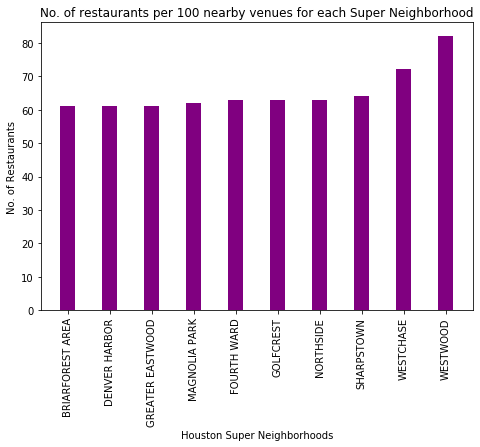

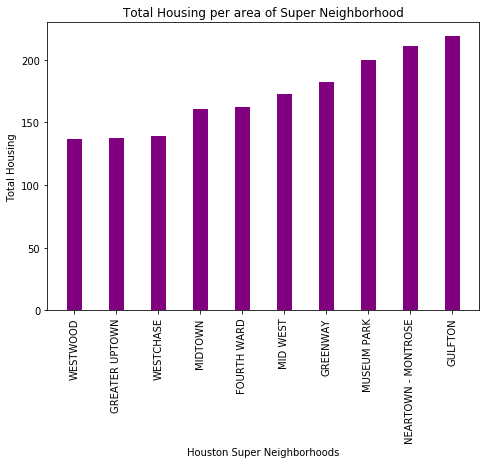

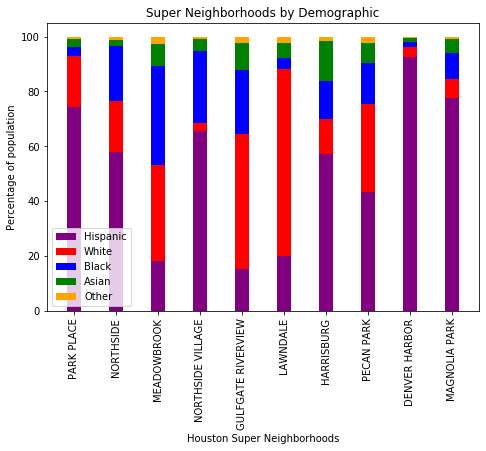

In [506]:
df_exploration = pd.DataFrame(df_final)

list_name = df_exploration["Name"]
list_rest = df_exploration["total_restaurants"]
list_housing = df_exploration["total_housing"]

sorted_rest, sorted_namerestden = zip(*sorted(zip(list_rest, list_name)))
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(sorted_namerestden[-10:], sorted_rest[-10:], width, color='purple')
ax.set_ylabel('No. of Restaurants')
ax.set_xlabel('Houston Super Neighborhoods')
plt.xticks(rotation='vertical')
ax.set_title('No. of restaurants per 100 nearby venues for each Super Neighborhood')
plt.show()



sorted_housing, sorted_namehou = zip(*sorted(zip(list_housing, list_name)))
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(sorted_namehou[-10:], pd.Series(sorted_housing[-10:])*1000000, width, color='purple')
ax.set_ylabel('Total Housing')
ax.set_xlabel('Houston Super Neighborhoods')
plt.xticks(rotation='vertical')
ax.set_title('Total Housing per area of Super Neighborhood')
plt.show()

list_pop = df_exploration["population_density"]

sorted_pop, sorted_namepop = zip(*sorted(zip(list_pop, list_name)))

list_asian = []
list_black = []
list_white = []
list_other = []
list_hispanic = []

for i in sorted_namepop[-10:] :
    a = float(df_exploration[df_exploration['Name']==i]['asian_population']) * 100
    b = float(df_exploration[df_exploration['Name']==i]['black_population']) * 100
    w = float(df_exploration[df_exploration['Name']==i]['white_population']) * 100
    h = float(df_exploration[df_exploration['Name']==i]['hispanic_population']) * 100
    
    
    
    list_asian.append(a)
    list_black.append(b)
    list_white.append(w)
    list_hispanic.append(h)
    list_other.append(100 - (a+b+w+h))


width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(sorted_namehispanic[-10:],list_hispanic, width, color='purple')
ax.bar(sorted_namehispanic[-10:],list_white, width, bottom=np.array(list_hispanic),color='red')
ax.bar(sorted_namehispanic[-10:],list_black, width, bottom=np.array(list_hispanic) + np.array(list_white)\
       ,color='blue')
ax.bar(sorted_namehispanic[-10:],list_asian, width, bottom=np.array(list_hispanic) + np.array(list_white)\
       + np.array(list_black),color='green')
ax.bar(sorted_namehispanic[-10:],list_other, width, bottom=np.array(list_hispanic) + np.array(list_white) \
       + np.array(list_black)+np.array(list_asian),color='orange')

ax.set_ylabel('Percentage of population')
ax.set_xlabel('Houston Super Neighborhoods')
plt.xticks(rotation='vertical')
ax.set_title('Super Neighborhoods by Demographic')
ax.legend(labels=['Hispanic', 'White','Black','Asian','Other'])
plt.show()

Normalizing the data for Clustering

In [507]:
df_clustering = pd.DataFrame(df_final)
df_clustering.drop(['Name'],axis=1,inplace=True)

x = df_clustering.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_clustering = pd.DataFrame(x_scaled)

df_clustering.head

<bound method NDFrame.head of            0         1         2         3         4         5         6
0   0.597015  0.159044  0.150974  0.128979  0.009452  0.022930  0.855857
1   0.567164  0.000000  0.005937  0.235658  0.246913  0.479603  0.217200
2   0.567164  0.234567  0.351742  0.016901  0.149377  1.000000  0.027648
3   0.656716  0.455066  0.398063  0.439038  0.500010  0.097755  0.272880
4   0.313433  0.345699  0.573758  0.025339  1.000000  0.369373  0.224529
..       ...       ...       ...       ...       ...       ...       ...
83  0.522388  0.335723  0.343446  0.368398  0.139678  0.421086  0.200411
84  0.850746  0.421906  0.625764  0.257677  0.280579  0.271200  0.374440
85  1.000000  0.550266  0.614441  0.648262  0.121369  0.030627  0.286973
86  0.522388  0.242088  0.288089  0.221100  0.221792  0.572959  0.168411
87  0.447761  0.132335  0.214927  0.220612  0.300433  0.372031  0.317162

[88 rows x 7 columns]>

Choosing the optimal no. of clusters using the elbow method

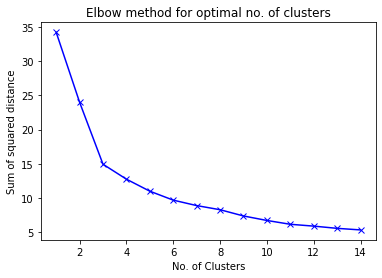

In [508]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_clustering)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('No. of Clusters')
plt.ylabel('Sum of squared distance')
plt.title('Elbow method for optimal no. of clusters')
plt.show()

KMeans Clustering

In [509]:
kclusters = 5

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustering)

kmeans.labels_

array([2, 1, 1, 3, 4, 3, 4, 0, 1, 0, 1, 0, 1, 2, 3, 1, 2, 2, 0, 3, 0, 1,
       0, 0, 2, 4, 3, 3, 0, 3, 1, 0, 0, 2, 4, 4, 3, 3, 0, 0, 0, 0, 0, 2,
       1, 1, 3, 3, 1, 2, 3, 3, 1, 1, 1, 4, 4, 0, 4, 4, 0, 3, 3, 2, 3, 3,
       2, 3, 2, 3, 2, 0, 2, 2, 3, 3, 1, 3, 2, 2, 1, 1, 1, 1, 4, 3, 1, 1],
      dtype=int32)

Adding columns for visualization on map

In [510]:
df_final["Clusters"] = kmeans.labels_
df_final['Latitude'] = list_latitide
df_final['Longitude'] = list_longitude

Visualization of clustered Super Neighborhoods of Houston on Map

In [511]:
address = 'Houston, USA'

geolocator = Nominatim(user_agent="houston_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_final['Latitude'], df_final['Longitude'], df_final['Name'], df_final['Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters